In [2]:
import pandas as pd
import numpy as np


meteorological_df = pd.read_csv('../../googledrive/data/meteorological.csv')

selected_columns = ['tm', 'stnId', 'stnNm', 'ta', 'rn', 'ws', 'wd', 'hm', 'pa']            # 시간, 관측소 번호, 이름, 온도, 온도 신뢰도, 강수량, 풍속, 풍향, 습도, 기압, 짐표온도 추출

filtered_df = meteorological_df[selected_columns]


# 위도 경도 데이터 추가. 위도 latitude, 경도 longitude
location_df = pd.read_csv('./location.csv')                                                                

location_columns = ['지점번호', '위도', '경도']
location_df = location_df[location_columns].rename(columns={'위도': 'latitude', '경도': 'longitude'})
df = pd.merge(filtered_df, location_df, 'left', left_on='stnId', right_on='지점번호')

df.drop(columns=['지점번호'], inplace=True)

df.head()

C:\Users\Jongho\AppData\Local\Temp\ipykernel_19876\2257190013.py:5: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  meteorological_df = pd.read_csv('../../googledrive/data/meteorological.csv')


,tm,stnId,stnNm,ta,rn,ws,wd,hm,pa,latitude,longitude
0,1971-07-01 09:00,100,대관령,21.1,NaN,NaN,NaN,78.0,NaN,37.67713,128.71834
1,1971-07-02 09:00,100,대관령,23.0,NaN,NaN,NaN,98.0,NaN,37.67713,128.71834
2,1971-07-03 09:00,100,대관령,20.2,NaN,NaN,NaN,100.0,NaN,37.67713,128.71834
3,1971-07-04 09:00,100,대관령,22.2,NaN,NaN,NaN,84.0,NaN,37.67713,128.71834
4,1971-07-05 09:00,100,대관령,22.7,NaN,NaN,NaN,79.0,NaN,37.67713,128.71834


In [3]:
import pandas as pd
import numpy as np

wd_df = pd.read_csv('wd.csv')
wd_values = wd_df['wd_values'].values

wd_values = sorted(set(wd_values))
wd_values = np.array(wd_values)

def nearest(value):
    if value in wd_values:
        return value
    else:
        closest_value = wd_values[np.abs(wd_values - value).argmin()]
        return closest_value


df['wd_mapped'] = df['wd'].apply(nearest)
df['wd_mapped'] = df['wd_mapped'].replace(360, 0)

wd_values = wd_values[wd_values != 360]

wd_columns = [f"wd_{int(wd)}" for wd in wd_values]
for wd in wd_values:
    column_name = f"wd_{int(wd)}"
    df[column_name] = np.where(df['wd_mapped'] == wd, df['ws'], 0)




In [4]:
# ta 결측치를 시간 순서대로 선형 보간
df['ta'] = df['ta'].interpolate(method='linear', limit_direction='both')

df['pa'] = df.groupby(df['tm'].str[:10])['pa'].transform('mean')  
df['pa'] = df['pa'].ffill().bfill()  # 남은 결측치는 보간

df['rn'] = df['rn'].fillna(0)  # 결측치를 0으로 채움

df['hm'] = df['hm'].interpolate(method='linear', limit_direction='both')  # 선형 보간

In [5]:
wd_columns = [f"wd_{int(wd)}" for wd in wd_values]

for wd in wd_values:
    column_name = f"wd_{int(wd)}"
    df[column_name] = np.where(df['wd_mapped'] == wd, df['ws'], 0)

df[wd_columns] = df[wd_columns].fillna(0)

df.drop(columns=['ws', 'wd'], inplace=True)

df['hour'] = pd.to_datetime(df['tm']).dt.hour
df['day'] = pd.to_datetime(df['tm']).dt.day
df['month'] = pd.to_datetime(df['tm']).dt.month
df['weekday'] = pd.to_datetime(df['tm']).dt.weekday


In [6]:
df.isna().sum()


tm           0
stnId        0
stnNm        0
ta           0
rn           0
hm           0
pa           0
latitude     0
longitude    0
wd_mapped    0
wd_0         0
wd_20        0
wd_50        0
wd_70        0
wd_90        0
wd_110       0
wd_140       0
wd_160       0
wd_180       0
wd_200       0
wd_230       0
wd_250       0
wd_270       0
wd_290       0
wd_320       0
wd_340       0
hour         0
day          0
month        0
weekday      0
dtype: int64

In [7]:
# 연속형 데이터와 타겟 변수 정의
features = [
    'latitude', 'rn', 'hm', 'pa',
    'wd_0', 'wd_20', 'wd_50', 'wd_70', 'wd_90', 'wd_110',
    'wd_140', 'wd_160', 'wd_180', 'wd_200', 'wd_230',
    'wd_250', 'wd_270', 'wd_290', 'wd_320', 'wd_340',
    'hour', 'day', 'month', 'weekday'
]

X_continuous = df[features].values.astype(np.float32)  # 연속형 데이터
y = df['ta'].values.astype(np.float32)  # 타겟 변수

# Label Encoding
from sklearn.preprocessing import LabelEncoder
stnId_encoder = LabelEncoder()
df['stnId_encoded'] = stnId_encoder.fit_transform(df['stnId'])
stnId_seq = df['stnId_encoded'].values.astype(np.int32)  # 임베딩 입력


In [8]:
def create_sequences(X, stnId, y, seq_length):
    X_seq, stnId_seq, y_seq = [], [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        stnId_seq.append(stnId[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(stnId_seq), np.array(y_seq)


seq_length = 10
X_seq, stnId_seq, y_seq = create_sequences(X_continuous, stnId_seq, y, seq_length)

print(f"X_seq shape: {X_seq.shape}")
print(f"stnId_seq shape: {stnId_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")


X_seq shape: (3902376, 10, 24)
stnId_seq shape: (3902376, 10)
y_seq shape: (3902376,)


In [9]:
# 데이터 크기 확인
print(f"Total samples: {len(X_seq)}")  # 전체 샘플 수

# 훈련/검증 데이터 분리
train_size = int(len(X_seq) * 0.8)  # 80%를 훈련 데이터로 사용
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
stnId_train, stnId_val = stnId_seq[:train_size], stnId_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# 크기 확인
print(f"X_train shape: {X_train.shape}")
print(f"stnId_train shape: {stnId_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"stnId_val shape: {stnId_val.shape}")
print(f"y_val shape: {y_val.shape}")


Total samples: 3902376
X_train shape: (3121900, 10, 24)
stnId_train shape: (3121900, 10)
y_train shape: (3121900,)
X_val shape: (780476, 10, 24)
stnId_val shape: (780476, 10)
y_val shape: (780476,)


In [10]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dropout


stnId_input_layer = Input(shape=(seq_length,), name="stnId_input")
stnId_embedding = Embedding(input_dim=len(stnId_encoder.classes_), output_dim=8, name="stnId_embedding")(stnId_input_layer)
#stnId_lstm = LSTM(8, name="stnId_lstm")(stnId_embedding)

stnId_lstm = LSTM(8, name="stnId_lstm", dropout=0.2, recurrent_dropout=0.2)(stnId_embedding)

continuous_input_layer = Input(shape=(seq_length, X_train.shape[2]), name="continuous_input")

#lstm_out = LSTM(64, return_sequences=False, name="continuous_lstm")(continuous_input_layer)

lstm_out = LSTM(64, return_sequences=False, name="continuous_lstm", dropout=0.2, recurrent_dropout=0.2)(continuous_input_layer)

concat = concatenate([stnId_lstm, lstm_out], axis=1)

dense_out = Dense(1, activation='relu')(concat)
dense_out = Dropout(0.2)(dense_out)

#dense_out = Dense(16, activation='relu')(concat)
#output = Dense(1, activation='linear')(dense_out)

model = Model(inputs=[stnId_input_layer, continuous_input_layer], outputs=dense_out)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stnId_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stnId_embedding     │ (None, 10, 8)     │        760 │ stnId_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_input    │ (None, 10, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stnId_lstm (LSTM)   │ (None, 8)         │        544 │ stnId_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_lstm     │ (None, 64)        │     22,784 │ continuous_input… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ stnId_lstm[0][0], │
│ (Concatenate)       │                   │            │ continuous_lstm[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         73 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1)         │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,161 (94.38 KB)

 Trainable params: 24,161 (94.38 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 모니터링
    patience=5,          # 개선되지 않는 Epoch 수
    restore_best_weights=True  # 최상의 가중치를 복원
)

history = model.fit(
    [stnId_train, X_train],
    y_train,
    validation_data=([stnId_val, X_val], y_val),
    epochs=20,
    batch_size=512,
    callbacks=[early_stopping]
)



Epoch 1/20


c:\anaconda3\envs\cv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['stnId_input', 'continuous_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


6098/6098 ━━━━━━━━━━━━━━━━━━━━ 212s 33ms/step - loss: 32.0627 - mae: 4.2917 - val_loss: 29.3581 - val_mae: 4.1303
Epoch 2/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - loss: 30.0858 - mae: 4.1466 - val_loss: 28.8163 - val_mae: 4.1020
Epoch 3/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 194s 32ms/step - loss: 29.9576 - mae: 4.1391 - val_loss: 28.8273 - val_mae: 4.1033
Epoch 4/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 202s 33ms/step - loss: 29.9116 - mae: 4.1352 - val_loss: 28.5228 - val_mae: 4.0792
Epoch 5/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - loss: 29.8027 - mae: 4.1294 - val_loss: 29.1211 - val_mae: 4.1322
Epoch 6/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 191s 31ms/step - loss: 29.7381 - mae: 4.1265 - val_loss: 28.6153 - val_mae: 4.0893
Epoch 7/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 179s 29ms/step - loss: 29.7464 - mae: 4.1251 - val_loss: 29.0825 - val_mae: 4.1334
Epoch 8/20
6098/6098 ━━━━━━━━━━━━━━━━━━━━ 199s 33ms/step - loss: 29.7652 - mae: 4.1263 - val_loss: 29.1059 - val_mae: 4.1322
Epoch 9/20


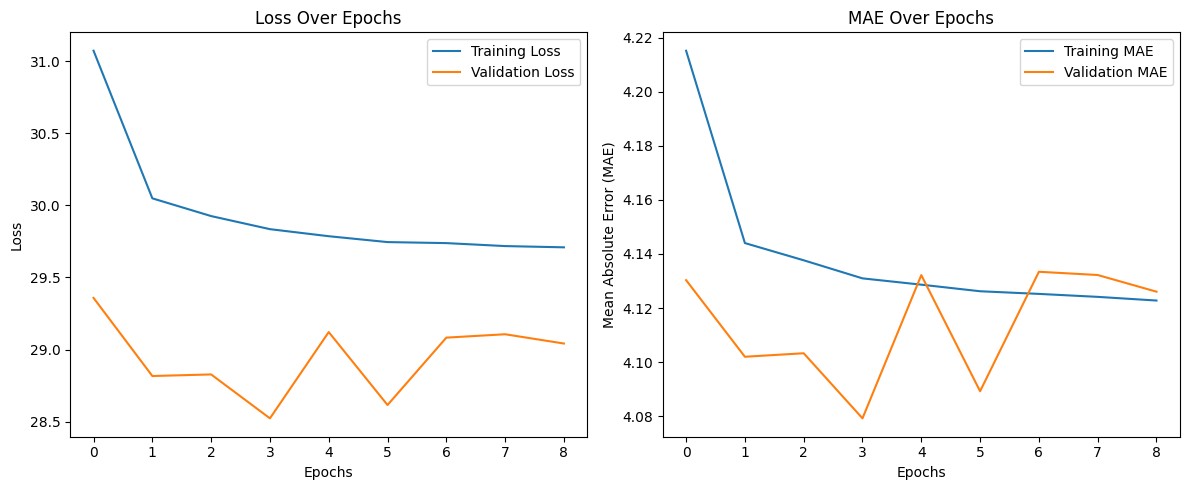

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 호출
plot_training_history(history)
